<a href="https://colab.research.google.com/github/yagoojoy/PINN_Taylor-Green-Vortex/blob/main/260116_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# 0. 환경 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
np.random.seed(42)
torch.manual_seed(42)

# 1. 데이터 생성 클래스 (지수항 통일 및 Deterministic Noise)
class FluidGenerator:
    def __init__(self, L=4.0, nu=0.001):
        self.L, self.nu = L, nu

    # [공통] 감쇠 함수 (신호와 노이즈 비율 유지)
    def get_decay(self, t):
        k = 1
        return np.exp(-2 * (k * np.pi)**2 * self.nu * t)

    def get_tgv_solution(self, X, Y, t):
        k = 1
        decay = self.get_decay(t)
        u = -1.0 * np.cos(k * np.pi * X) * np.sin(k * np.pi * Y) * decay
        v =  1.0 * np.sin(k * np.pi * X) * np.cos(k * np.pi * Y) * decay
        p = -0.25 * (np.cos(2 * k * np.pi * X) + np.cos(2 * k * np.pi * Y)) * (decay**2)
        return u, v, p

    def get_unphysical_noise(self, X, Y, t):
        # 결정론적 노이즈 (함수 형태이므로 임의의 t에 대해 생성 가능)
        noise_scale = 0.05 * self.get_decay(t)
        u_n = noise_scale * np.sin(8 * np.pi * X / self.L) * np.sin(8 * np.pi * Y / self.L)
        v_n = noise_scale * np.cos(8 * np.pi * X / self.L) * np.cos(8 * np.pi * Y / self.L)
        p_n = noise_scale * 0.25 * (np.sin(4 * np.pi * X / self.L))
        return u_n, v_n, p_n

    def get_data_at_t(self, nx, ny, t_val):
        x, y = np.linspace(0, self.L, nx), np.linspace(0, self.L, ny)
        X, Y = np.meshgrid(x, y)
        u_hf, v_hf, p_hf = self.get_tgv_solution(X, Y, t_val)
        u_n, v_n, p_n = self.get_unphysical_noise(X, Y, t_val)

        # LF = HF + Noise
        u_lf, v_lf, p_lf = u_hf + u_n, v_hf + v_n, p_hf + p_n

        return X, Y, u_lf, v_lf, p_lf, u_hf, v_hf, p_hf

# 2. 데이터셋 구성 (입력에 LF 포함)
L_val, nu_val, GRID = 4.0, 0.01, 100
T_max_train = 10.0
T_scale = 13.0 # 정규화 상수
generator = FluidGenerator(L=L_val, nu=nu_val)
train_times = np.linspace(0, T_max_train, 11) # 0, 1, ..., 10

# 리스트 초기화
x_list, y_list, t_list = [], [], []
u_lf_list, v_lf_list, p_lf_list = [], [], [] # [NEW] 입력으로 사용될 LF
u_hf_list, v_hf_list, p_hf_list = [], [], [] # [NEW] 타겟으로 사용될 HF

print("Generating Data: Inputs (x,y,t, LF) -> Targets (HF)...")
for t in train_times:
    X, Y, u_l, v_l, p_l, u_h, v_h, p_h = generator.get_data_at_t(GRID, GRID, t)

    x_list.append(X.flatten())
    y_list.append(Y.flatten())
    t_list.append(np.full(X.size, t))

    # LF를 입력(Feature)으로 저장
    u_lf_list.append(u_l.flatten())
    v_lf_list.append(v_l.flatten())
    p_lf_list.append(p_l.flatten())

    # HF를 정답(Target)으로 저장
    u_hf_list.append(u_h.flatten())
    v_hf_list.append(v_h.flatten())
    p_hf_list.append(p_h.flatten())

# 텐서 변환
# 1. 좌표 입력
x_train = torch.tensor(np.concatenate(x_list)/L_val, dtype=torch.float32).view(-1, 1).to(device)
y_train = torch.tensor(np.concatenate(y_list)/L_val, dtype=torch.float32).view(-1, 1).to(device)
t_train = torch.tensor(np.concatenate(t_list)/T_scale, dtype=torch.float32).view(-1, 1).to(device)

# 2. LF 유동장 입력 (Input Features)
u_lf_train = torch.tensor(np.concatenate(u_lf_list), dtype=torch.float32).view(-1, 1).to(device)
v_lf_train = torch.tensor(np.concatenate(v_lf_list), dtype=torch.float32).view(-1, 1).to(device)
p_lf_train = torch.tensor(np.concatenate(p_lf_list), dtype=torch.float32).view(-1, 1).to(device)

# 3. HF 유동장 타겟 (Labels)
u_hf_train = torch.tensor(np.concatenate(u_hf_list), dtype=torch.float32).view(-1, 1).to(device)
v_hf_train = torch.tensor(np.concatenate(v_hf_list), dtype=torch.float32).view(-1, 1).to(device)
p_hf_train = torch.tensor(np.concatenate(p_hf_list), dtype=torch.float32).view(-1, 1).to(device)

# 3. 모델 정의 (입력 차원 증가: 3 -> 6)
class FourierEmbedding(nn.Module):
    def __init__(self, in_channels, scale=4.0):
        super().__init__()
        # 좌표(x,y,t)에 대해서만 Fourier Feature를 적용하는 것이 일반적이나,
        # 여기서는 전체 입력 6개에 대해 적용하거나, 좌표만 적용 후 LF는 concat할 수 있습니다.
        # 간단하고 강력한 성능을 위해 6개 채널 모두 임베딩하거나,
        # 좌표 3개만 임베딩하고 나머지는 그냥 붙이는 방식을 씁니다.
        # 여기서는 "좌표(3) 임베딩 + LF(3) 원본" 구조를 추천합니다. (물리적 위치 정보 강조)
        self.register_buffer("B", torch.randn(3, 128) * scale) # 좌표용 B

    def forward(self, coords, fields):
        # coords: x, y, t
        # fields: u_lf, v_lf, p_lf
        x_proj = 2 * np.pi * coords @ self.B
        emb = torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)
        # 임베딩된 좌표 특징과 원본 LF 값을 결합
        return torch.cat([emb, fields], dim=-1)

class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = FourierEmbedding(in_channels=3) # 좌표 3개 임베딩
        # 입력 크기: (128*2) + 3(LF fields) = 259
        self.net = nn.Sequential(
            nn.Linear(256 + 3, 128), nn.SiLU(),
            nn.Linear(128, 128), nn.SiLU(),
            nn.Linear(128, 128), nn.SiLU(),
            nn.Linear(128, 128), nn.SiLU(),
            nn.Linear(128, 128), nn.SiLU(),
            nn.Linear(128, 3) # Output: HF correction
        )
    def forward(self, x, y, t, u_lf, v_lf, p_lf):
        coords = torch.cat([x, y, t], dim=1)
        fields = torch.cat([u_lf, v_lf, p_lf], dim=1)
        return self.net(self.embedding(coords, fields))

# 4. Phase 0: Warm-up (Supervised Learning: LF input -> HF output)
model = PINN().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

print("\n--- Phase 0: Warm-up (Learning to map LF to HF) ---")
for epoch in range(1501):
    optimizer.zero_grad()
    # 입력으로 LF 데이터도 함께 줍니다.
    pred = model(x_train, y_train, t_train, u_lf_train, v_lf_train, p_lf_train)

    # 타겟은 HF 데이터입니다.
    loss = torch.mean((pred[:,0:1]-u_hf_train)**2 + \
                      (pred[:,1:2]-v_hf_train)**2 + \
                      (pred[:,2:3]-p_hf_train)**2)

    loss.backward()
    optimizer.step()

    if epoch % 300 == 0: print(f"Epoch {epoch} | Loss: {loss.item():.6f}")
    if loss.item() < 0.0005: break

torch.save(model.state_dict(), "warmup_model.pth")

Generating Data: Inputs (x,y,t, LF) -> Targets (HF)...

--- Phase 0: Warm-up (Learning to map LF to HF) ---
Epoch 0 | Loss: 0.158489



--- Phase 1: Physics Training with Focused Sampling ---
Ep     0 | Total: 0.000369 | Data: 0.000492 | PDE: 0.531415
         > Last 500 eps: 0.82s | Total: 0.0m
Ep   500 | Total: 0.001193 | Data: 0.000245 | PDE: 0.010087
         > Last 500 eps: 406.54s | Total: 6.8m
Ep  1000 | Total: 0.000461 | Data: 0.000106 | PDE: 0.001907
         > Last 500 eps: 409.28s | Total: 13.6m
Ep  1500 | Total: 0.000259 | Data: 0.000073 | PDE: 0.000679
         > Last 500 eps: 409.49s | Total: 20.4m
Ep  2000 | Total: 0.000178 | Data: 0.000063 | PDE: 0.000327
         > Last 500 eps: 408.42s | Total: 27.3m
Ep  2500 | Total: 0.000139 | Data: 0.000059 | PDE: 0.000189
         > Last 500 eps: 408.15s | Total: 34.1m
Ep  3000 | Total: 0.000118 | Data: 0.000057 | PDE: 0.000125
         > Last 500 eps: 407.18s | Total: 40.9m
Ep  3500 | Total: 0.000104 | Data: 0.000057 | PDE: 0.000087
         > Last 500 eps: 408.11s | Total: 47.7m
Ep  4000 | Total: 0.000097 | Data: 0.000057 | PDE: 0.000068
         > Last 500 eps

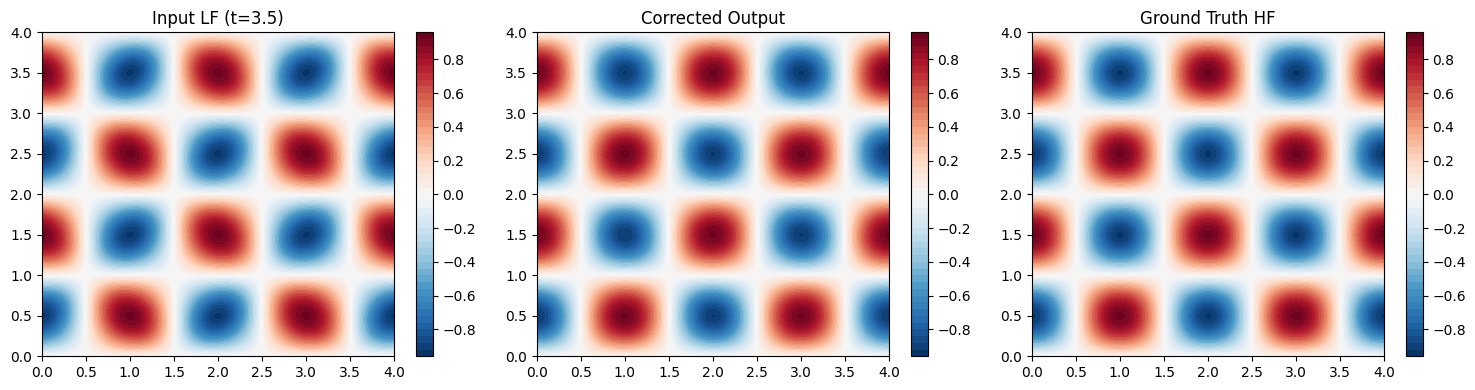


[Extrapolation (t=11.5)] Time t=11.5
Input MSE (LF vs HF): 0.00038903
Output MSE (Pred vs HF): 0.00001564
Improvement: 95.98%


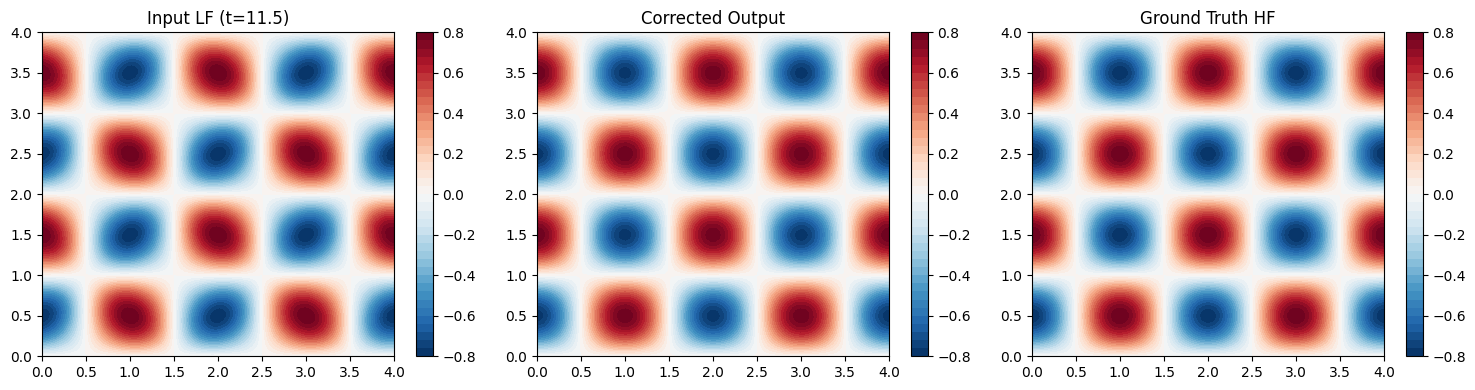

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time

def clear_memory():
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# 파라미터 유지
L_val = 4.0
nu_val = 0.001
T_scale = 13.0
T_pred_max = 13.0
T_train_max = 10.0 # 학습 데이터의 한계 시점

generator = FluidGenerator(L=L_val, nu=nu_val)

# 1. 물리 식 정의 (동일)
def get_pde_loss(model, x, y, t, u_lf_in, v_lf_in, p_lf_in, nu, L, T_scale):
    out = model(x, y, t, u_lf_in, v_lf_in, p_lf_in)
    u, v, p = out[:, 0:1], out[:, 1:2], out[:, 2:3]

    def grad(outputs, inputs):
        return torch.autograd.grad(outputs, inputs, torch.ones_like(outputs), create_graph=True)[0]

    u_t = grad(u, t) / T_scale
    v_t = grad(v, t) / T_scale
    u_x_raw, u_y_raw = grad(u, x), grad(u, y)
    v_x_raw, v_y_raw = grad(v, x), grad(v, y)
    p_x_raw, p_y_raw = grad(p, x), grad(p, y)

    u_x, u_y = u_x_raw/L, u_y_raw/L
    v_x, v_y = v_x_raw/L, v_y_raw/L
    p_x, p_y = p_x_raw/L, p_y_raw/L

    u_xx, u_yy = grad(u_x_raw, x)/(L**2), grad(u_y_raw, y)/(L**2)
    v_xx, v_yy = grad(v_x_raw, x)/(L**2), grad(v_y_raw, y)/(L**2)

    f_mass = u_x + v_y
    f_u = u_t + (u*u_x + v*u_y) + p_x - nu*(u_xx + u_yy)
    f_v = v_t + (u*v_x + v*v_y) + p_y - nu*(v_xx + v_yy)

    return torch.mean(f_mass**2), torch.mean(f_u**2 + f_v**2)

# 2. 학습 준비
clear_memory()
model = PINN().to(device)
model.load_state_dict(torch.load("warmup_model.pth"))

# PDE용 그리드 설정 (기본 틀)
nt_p, nx_p, ny_p = 30, 40, 40 # 샘플 개수 살짝 조정
t_g = torch.linspace(0, T_pred_max/T_scale, nt_p, device=device)
x_g = torch.linspace(0, 1, nx_p, device=device)
y_g = torch.linspace(0, 1, ny_p, device=device)
# 메쉬그리드는 shape 참조용으로만 사용
T_m, X_m, Y_m = torch.meshgrid(t_g, x_g, y_g, indexing='ij')

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# ==========================================
# 3. Phase 1: Physics Training (Focus Sampling)
# ==========================================
print("\n--- Phase 1: Physics Training with Focused Sampling ---")

phase1_start_time = time.time()
block_start_time = time.time()

# [전략] 배치의 절반은 0~10초(학습영역), 절반은 10~13초(외삽영역)에서 샘플링
half_size = T_m.numel() // 2

for epoch in range(5001):
    if epoch == 5000:
        for pg in optimizer.param_groups: pg['lr'] = 5e-5

    optimizer.zero_grad()

    # --- [수정된 샘플링 로직 시작] ---
    # 1. 학습 구간 (0 ~ 10초) 샘플링
    t_1 = torch.rand(half_size, 1, device=device) * (T_train_max / T_scale)

    # 2. 외삽 구간 (10 ~ 13초) 샘플링 -> 모델에게 "여기를 잘 봐!"라고 강제
    t_2 = torch.rand(half_size, 1, device=device) * ((T_pred_max - T_train_max) / T_scale) + (T_train_max / T_scale)

    # 3. 합치기
    t_rand = torch.cat([t_1, t_2], dim=0)

    # x, y는 전체 구간(0~1)에서 랜덤
    x_rand = torch.rand(half_size * 2, 1, device=device)
    y_rand = torch.rand(half_size * 2, 1, device=device)

    # 실제 물리 좌표로 변환 (LF 생성용)
    x_phys_np = x_rand.cpu().numpy() * L_val
    y_phys_np = y_rand.cpu().numpy() * L_val
    t_phys_np = t_rand.cpu().numpy() * T_scale

    # LF 값 생성
    u_h_np, v_h_np, p_h_np = generator.get_tgv_solution(x_phys_np, y_phys_np, t_phys_np)
    u_n_np, v_n_np, p_n_np = generator.get_unphysical_noise(x_phys_np, y_phys_np, t_phys_np)

    u_lf_in = torch.tensor(u_h_np + u_n_np, dtype=torch.float32).to(device)
    v_lf_in = torch.tensor(v_h_np + v_n_np, dtype=torch.float32).to(device)
    p_lf_in = torch.tensor(p_h_np + p_n_np, dtype=torch.float32).to(device)

    # Gradient 추적 설정
    x_p = x_rand.requires_grad_(True)
    y_p = y_rand.requires_grad_(True)
    t_p = t_rand.requires_grad_(True)
    # --- [수정된 샘플링 로직 끝] ---

    # 1. Data Loss
    pred_data = model(x_train, y_train, t_train, u_lf_train, v_lf_train, p_lf_train)
    l_data = torch.mean((pred_data[:,0:1]-u_hf_train)**2 + \
                        (pred_data[:,1:2]-v_hf_train)**2 + \
                        (pred_data[:,2:3]-p_hf_train)**2)

    # 2. PDE Loss (집중 샘플링된 점들)
    l_mass, l_mom = get_pde_loss(model, x_p, y_p, t_p, u_lf_in, v_lf_in, p_lf_in, nu_val, L_val, T_scale)

    pde_w = min(1.0 * (epoch/5000), 1.0)
    total_loss = 0.75 * l_data + pde_w * (l_mass + l_mom)

    total_loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        current_time = time.time()
        block_duration = current_time - block_start_time
        total_elapsed = current_time - phase1_start_time
        print(f"Ep {epoch:5d} | Total: {total_loss.item():.6f} | Data: {l_data.item():.6f} | PDE: {l_mass.item()+l_mom.item():.6f}")
        print(f"         > Last 500 eps: {block_duration:.2f}s | Total: {total_elapsed/60:.1f}m")
        block_start_time = time.time()

# ==========================================
# 4. Phase 2: L-BFGS
# ==========================================
print("\n--- Phase 2: Refinement (L-BFGS) ---")
lbfgs = optim.LBFGS(model.parameters(), max_iter=2000, history_size=50, line_search_fn="strong_wolfe")

def closure():
    lbfgs.zero_grad()
    out = model(x_train, y_train, t_train, u_lf_train, v_lf_train, p_lf_train)
    ld = torch.mean((out[:,0:1]-u_hf_train)**2 + (out[:,1:2]-v_hf_train)**2 + (out[:,2:3]-p_hf_train)**2)
    lm, lmo = get_pde_loss(model, x_p, y_p, t_p, u_lf_in, v_lf_in, p_lf_in, nu_val, L_val, T_scale)
    loss = 0.75 * ld + 1.0 * (lm + lmo) # PDE 가중치 1.0 유지
    if loss.requires_grad: loss.backward()
    return loss

lbfgs_start_time = time.time()
lbfgs.step(closure)
lbfgs_end_time = time.time()
print(f"L-BFGS Complete. Duration: {lbfgs_end_time - lbfgs_start_time:.2f} sec")

# ==========================================
# 5. 결과 검증
# ==========================================
def test_correction(test_t, scenario_name):
    X_g, Y_g, u_l, v_l, p_l, u_h, v_h, p_h = generator.get_data_at_t(GRID, GRID, test_t)

    x_in = torch.tensor(X_g.flatten()/L_val, dtype=torch.float32).view(-1, 1).to(device)
    y_in = torch.tensor(Y_g.flatten()/L_val, dtype=torch.float32).view(-1, 1).to(device)
    t_in = torch.tensor(np.full(x_in.shape, test_t/T_scale), dtype=torch.float32).view(-1, 1).to(device)

    u_lf_in = torch.tensor(u_l.flatten(), dtype=torch.float32).view(-1, 1).to(device)
    v_lf_in = torch.tensor(v_l.flatten(), dtype=torch.float32).view(-1, 1).to(device)
    p_lf_in = torch.tensor(p_l.flatten(), dtype=torch.float32).view(-1, 1).to(device)

    model.eval()
    with torch.no_grad():
        out = model(x_in, y_in, t_in, u_lf_in, v_lf_in, p_lf_in)
        u_pred = out[:, 0].cpu().numpy().reshape(GRID, GRID)

    mse_lf = np.mean((u_l - u_h)**2)
    mse_pinn = np.mean((u_pred - u_h)**2)

    print(f"\n[{scenario_name}] Time t={test_t}")
    print(f"Input MSE (LF vs HF): {mse_lf:.8f}")
    print(f"Output MSE (Pred vs HF): {mse_pinn:.8f}")
    if mse_lf > 1e-12:
        print(f"Improvement: {(mse_lf - mse_pinn)/mse_lf * 100:.2f}%")
    else:
        print("Improvement: N/A")

    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1); plt.title(f"Input LF (t={test_t})"); plt.contourf(X_g, Y_g, u_l, 50, cmap='RdBu_r'); plt.colorbar()
    plt.subplot(1, 3, 2); plt.title("Corrected Output"); plt.contourf(X_g, Y_g, u_pred, 50, cmap='RdBu_r'); plt.colorbar()
    plt.subplot(1, 3, 3); plt.title("Ground Truth HF"); plt.contourf(X_g, Y_g, u_h, 50, cmap='RdBu_r'); plt.colorbar()
    plt.tight_layout(); plt.show()

test_correction(3.5, "Interpolation (t=3.5)")
test_correction(11.5, "Extrapolation (t=11.5)")